# Tempo

Tempo should be measured as either the amount of passes and dribbles per time frame, or the speed of those per time frame. It could also include for example goal kicks, free kicks, corner kicks and even shots. Let's start with passes and dribbles.

In [232]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [233]:
# read data
df = pd.read_csv('../data/timelines.csv')

In [234]:
# unique match pairs
unique_match_ids = df['match_id'].unique()
df[(df['match_id'].isin(unique_match_ids)) & (df['match_id'] != df['match_id'].shift(1))][['home_team', 'away_team', 'year']].value_counts().reset_index(name='count')

,home_team,away_team,year,count
0,EPS T2010,K3 SPL United T2010,2024,2
1,Ilves P2009,Midtjylland P2009,2023,2
2,KäPa P2010,Vitesse P2010,2022,1
3,Nordsjaelland T2008,TPS T2008,2022,1
4,Nordsjaelland T2008,SPL United 1 T2008,2022,1
...,...,...,...,...
467,Hammarby T2009,FC Nokia T2009,2022,1
468,Hammarby T2009,Brommapojkarna T2009,2022,1
469,Hammarby T2008,Nordsjaelland T2008,2022,1
470,Hammarby T2008,Ilves T2008,2022,1


In [235]:
# head
df.head(1)

,tournament_id,match_id,event_type,period,result,team,seconds_from_period_start,start_time,end_time,start_position_x,start_position_y,end_position_x,end_position_y,speed,home_team,away_team,home_team_int,away_team_int,age,year,distance,duration,int_level
0,57,1257,KickOff,1.0,NaN,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FC Espoo T2010,EPS T2010,0,0,F12,2022,NaN,NaN,0


In [236]:
# group by matches
df_matches = df.groupby('match_id')

In [237]:
# get matches with time gaps between events of over 50 seconds
threshold = 50

# Compute time gaps
df['time_gap'] = df_matches['seconds_from_period_start'].diff()

# Identify matches with gaps above threshold
df['gap_exceeds_threshold'] = df['time_gap'] > threshold
df['gap_exceeds_threshold_60'] = df['time_gap'] > 60

In [238]:
# get matches where two consecutive events are kick-offs
df['consecutive_kickoffs'] = (df['event_type'] == 'KickOff') & (df['event_type'].shift(1) == 'KickOff')

We should decide which matches we want to keep. Some matches have large gaps between events, which could be pauses in the match or an error of the data gathering system. Below are a few options.

In [239]:
# remove matches where two consecutive events are kickoffs and have at least a 50 second gap
# remove_match_indices = df[(df['gap_exceeds_threshold'] == True) & (df['consecutive_kickoffs'] == True)]['match_id'].unique()
# df = df[~df['match_id'].isin(remove_match_indices)]

In [240]:
# remove matches with time gaps of over a minute
remove_match_indices = df[(df['gap_exceeds_threshold_60'] == True)]['match_id'].unique()
df = df[~df['match_id'].isin(remove_match_indices)]

### Plotting

In [241]:
# Function to calculate passes & dribbles per timeframe
def calculate_tempo(df, timeframe):
    
    # Create time bins
    df['time_bin'] = (df['seconds_from_period_start'] // timeframe) * timeframe
    
    # Count passes & dribbles per time bin
    tempo_df = df[df['event_type'].isin(['Pass', 'Dribble'])] \
        .groupby(['match_id', 'time_bin', 'age', 'int_level']).size().reset_index(name='tempo')
    
    return tempo_df

In [242]:
# passes and dribbles
df_passes_dribbles = df[df['event_type'].isin(['Pass', 'Dribble'])]

df_grouped = df_passes_dribbles.groupby(['age', 'period'])

for i, (group_name, df_group) in enumerate(df_grouped):
    print(group_name)
    print(calculate_tempo(df_group, 240))

('F12', 1.0)
     match_id  time_bin  age  int_level  tempo
0        1237       0.0  F12          1     21
1        1237     240.0  F12          1     39
2        1237     480.0  F12          1     29
3        1237     720.0  F12          1     27
4        1237     960.0  F12          1     48
..        ...       ...  ...        ...    ...
298      3164     240.0  F12          0     30
299      3164     480.0  F12          0     32
300      3164     720.0  F12          0     40
301      3164     960.0  F12          0     25
302      3164    1200.0  F12          0      1

[303 rows x 5 columns]
('F12', 2.0)
    match_id  time_bin  age  int_level  tempo
0       1237       0.0  F12          1     15
1       1238       0.0  F12          0     10
2       1240       0.0  F12          0     28
3       1240     240.0  F12          0     30
4       1240     480.0  F12          0     13
..       ...       ...  ...        ...    ...
57      3162       0.0  F12          1     15
58      3162     2

We can tell that the second period looks useless in all age groups, only a few time frames in some matches. We should ignore these completely. Also, we should be cautious about the last time frame of the match as it is not probably of equal duration to the other frames.

In [243]:
# include only period 1 events
df = df[df['period'] == 1.0]

In [244]:
# get the tempo dataframe
tempo_df = calculate_tempo(df, 180)

In [245]:
# Find the max time_bin for each match_id
max_time_bins = tempo_df.groupby('match_id')['time_bin'].transform('max')

# Keep only rows where time_bin is NOT the max for that match
tempo_df = tempo_df[tempo_df['time_bin'] != max_time_bins]

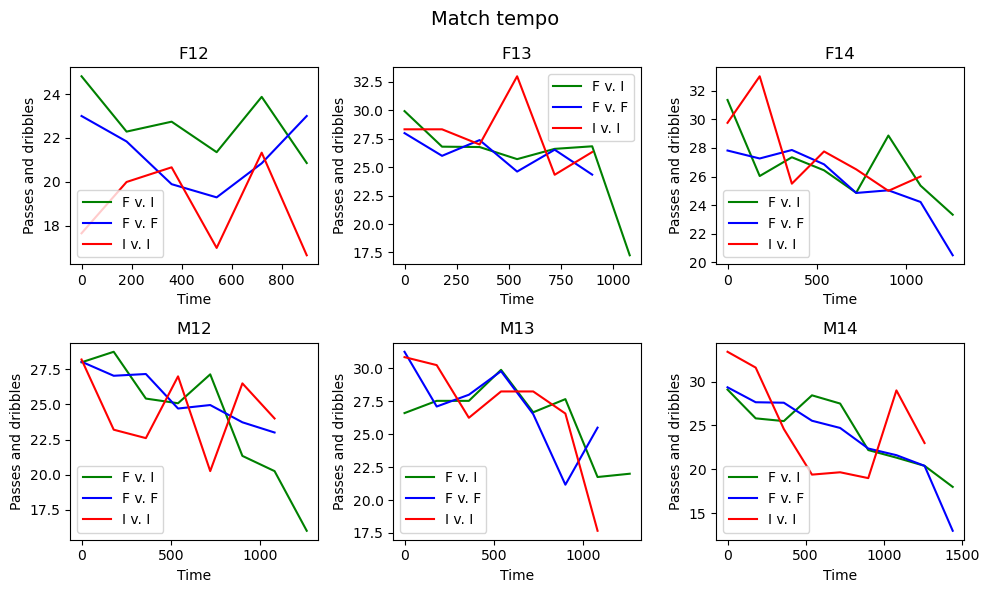

In [246]:
# plot histograms of pass speeds per age group
fig, axes = plt.subplots(2,3, figsize=(10,6))

colors = ['blue', 'green', 'red']

axes = axes.flatten()

df_grouped = tempo_df.groupby('age')

for i, (group_name, df_group) in enumerate(df_grouped):

    # Group by int_level within each age group
    int_levels = df_group['int_level'].unique()  # Get unique intensity levels

    for level in int_levels: # [1, 0, 2]
        subset = df_group[df_group['int_level'] == level]
        avg = subset.groupby('time_bin')['tempo'].mean()
        axes[i].plot(avg, color=colors[level], label=f'{['F v. F', 'F v. I', 'I v. I'][level]}')

    axes[i].set_title(group_name)
    axes[i].legend()  # Add legend to differentiate int_level categories
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Passes and dribbles')

fig.suptitle('Match tempo', fontsize=14)
plt.tight_layout()

In [247]:
df

,tournament_id,match_id,event_type,period,result,team,seconds_from_period_start,start_time,end_time,start_position_x,start_position_y,end_position_x,end_position_y,speed,home_team,away_team,home_team_int,away_team_int,age,year,distance,duration,int_level,time_gap,gap_exceeds_threshold,gap_exceeds_threshold_60,consecutive_kickoffs,time_bin
153,57,1256,KickOff,1.0,NaN,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hammarby T2010,KuPS T2010,1,0,F12,2022,NaN,NaN,1,NaN,False,False,False,NaN
154,57,1256,KickOff,1.0,NaN,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hammarby T2010,KuPS T2010,1,0,F12,2022,NaN,NaN,1,NaN,False,False,True,NaN
155,57,1256,Pass,1.0,Intercepted,Away,1.0,2022-11-22 10:31:03.880000+00:00,2022-11-22 10:31:05.700000+00:00,8.88,-0.12,-9.68,-11.87,12.069618,Hammarby T2010,KuPS T2010,1,0,F12,2022,21.966704,1.82,1,NaN,False,False,False,0.0
156,57,1256,Dribble,1.0,Successful,Away,4.0,2022-11-22 10:31:06.820000+00:00,2022-11-22 10:31:08.380000+00:00,-15.25,-16.02,-22.61,-15.38,4.735752,Hammarby T2010,KuPS T2010,1,0,F12,2022,7.387774,1.56,1,3.0,False,False,False,0.0
157,57,1256,Pass,1.0,Intercepted,Away,6.0,2022-11-22 10:31:09.380000+00:00,2022-11-22 10:31:10.500000+00:00,-29.70,-14.23,-31.96,-3.07,10.166550,Hammarby T2010,KuPS T2010,1,0,F12,2022,11.386536,1.12,1,2.0,False,False,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136081,157,3275,BallContest,1.0,NaN,NaN,1182.0,2024-12-18 11:34:25.980000+00:00,2024-12-18 11:34:26.300000+00:00,6.64,18.13,NaN,NaN,NaN,Shamrock Rovers P2012,Bröndby IF P2012,1,1,M12,2024,NaN,0.32,2,1.0,False,False,False,1080.0
136082,157,3275,Pass,1.0,Successful,Home,1189.0,2024-12-18 11:34:32.380000+00:00,2024-12-18 11:34:34.120000+00:00,3.81,-2.07,9.17,10.60,7.906394,Shamrock Rovers P2012,Bröndby IF P2012,1,1,M12,2024,13.757125,1.74,2,7.0,False,False,False,1080.0
136083,157,3275,Pass,1.0,Intercepted,Home,1192.0,2024-12-18 11:34:35.380000+00:00,2024-12-18 11:34:39.200000+00:00,8.24,10.37,43.49,-0.72,9.673654,Shamrock Rovers P2012,Bröndby IF P2012,1,1,M12,2024,36.953357,3.82,2,3.0,False,False,False,1080.0
136084,157,3275,Pass,1.0,Successful,Away,1197.0,2024-12-18 11:34:40.740000+00:00,2024-12-18 11:34:42.480000+00:00,44.19,-1.75,43.75,8.60,5.953649,Shamrock Rovers P2012,Bröndby IF P2012,1,1,M12,2024,10.359348,1.74,2,5.0,False,False,False,1080.0


Not very informative. We could also further process the data to remove matches where there are large gaps in the time frames. It was thought that they were pauses in the match, which they still could be, but they could also be the systems fault.

We will focus next on the team-wise tempo per possession. For this we need to first derive the team in position in each moment. Then we can derive the duration of said possession, and calculate the amount of passes and dribbles per possession.

In [248]:
# check team
pd.options.display.max_rows = 10
simple_df = df[['match_id', 'event_type', 'team', 'result', 'seconds_from_period_start', 'home_team_int', 'away_team_int', 'age', 'time_gap', ]]

In [285]:
grouped_matches = simple_df.groupby('match_id')

for group_name, df_group in grouped_matches:

    # create a possession identifier by checking when the value changes
    df_group['possession_id'] = (df_group['team'] != df_group['team'].shift()).cumsum()

    # calculate possession duration
    df_group['possession_duration'] = df_group.groupby('possession_id')['seconds_from_period_start'].transform('max') - \
                                df_group.groupby('possession_id')['seconds_from_period_start'].transform('min')
    

    # Filter possessions that have at least 3 events
    valid_possessions = df_group.groupby(['match_id', 'team', 'possession_id']).filter(lambda x: len(x) >= 3)

    # Group by possession and calculate pass and dribble counts
    df_possessions = valid_possessions.groupby(['match_id', 'possession_id']).agg(
        pos_duration=('possession_duration', 'first'),  # Assuming duration is the same for all events in a possession
        pass_count=('event_type', lambda x: (x == 'Pass').sum()),  # Count passes
        dribble_count=('event_type', lambda x: (x == 'Dribble').sum())  # Count dribbles
    ).reset_index()

    df_possessions['pos_event_amt'] = df_possessions['pass_count'] + df_possessions['dribble_count']

    # Calculate tempo as events per second (or another relevant formula)
    df_possessions['pos_tempo'] = (df_possessions['pos_event_amt']) / df_possessions['pos_duration']

    print(df_possessions)

    match_id  possession_id  pos_duration  pass_count  dribble_count  \
0       1237              1           4.0           2              0   
1       1237             40          16.0           1              0   
2       1237             43           8.0           2              1   
3       1237             47          15.0           4              0   
4       1237             51          10.0           4              1   
5       1237             59           6.0           2              0   
6       1237             63           4.0           3              0   
7       1237             66           6.0           2              1   
8       1237             72           9.0           3              0   
9       1237             78           6.0           3              0   
10      1237             81          10.0           3              0   
11      1237             82          10.0           3              1   
12      1237             87          14.0           4           

In [ ]:
# create dataframe with columns: 'match_id', 'team', 'pos_event_amt', 'pos_duration', 'pos_tempo'
def calculate_tempo_per_possession(df):

    # Group by match
    grouped_mathces = df.groupby(['match_id', 'age'])

    for group_name, df_group in grouped_mathces:
        
    
    # Filter possessions longer than two events
    possession_stats = possession_stats[possession_stats['passes_and_dribbles'] > 2]
    
    # Compute tempo for each possession
    possession_stats['tempo'] = possession_stats['passes_and_dribbles'] / possession_stats['possession_time']
    
    # Aggregate by team
    team_stats = possession_stats.groupby('team').agg(
        total_passes_dribbles=('passes_and_dribbles', 'sum'),
        total_possession_time=('possession_time', 'sum'),
        average_tempo=('tempo', 'mean')  # Average tempo of possessions
    ).reset_index()
    
    # Compute tempo for the match (total events / total possession time)
    team_stats['match_tempo'] = team_stats['total_passes_dribbles'] / team_stats['total_possession_time']
    
    return df

# Calculate tempo
tempo_df = calculate_tempo(simple_df)
tempo_df


,match_id,event_type,team,result,seconds_from_period_start,home_team_int,away_team_int,age,time_gap,possession_change,possession_id,next_event_time,event_duration
155,1256,Pass,Away,Intercepted,1.0,1,0,F12,NaN,True,1,4.0,3.0
156,1256,Dribble,Away,Successful,4.0,1,0,F12,3.0,False,1,6.0,2.0
157,1256,Pass,Away,Intercepted,6.0,1,0,F12,2.0,False,1,10.0,4.0
159,1256,Pass,Home,Intercepted,10.0,1,0,F12,2.0,True,2,20.0,10.0
163,1256,Pass,Away,Intercepted,20.0,1,0,F12,1.0,True,3,25.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
136080,3275,Pass,Home,Successful,1181.0,1,1,M12,2.0,False,21516,1189.0,8.0
136082,3275,Pass,Home,Successful,1189.0,1,1,M12,7.0,False,21516,1192.0,3.0
136083,3275,Pass,Home,Intercepted,1192.0,1,1,M12,3.0,False,21516,1197.0,5.0
136084,3275,Pass,Away,Successful,1197.0,1,1,M12,5.0,True,21517,1204.0,7.0
